   alpha_HH  alpha_HV1  alpha_HV2  alpha_PH  avg_diffusion
0       0.0        0.0        0.0       0.0       1.000000
1       0.0        0.0        0.0       2.5       0.434418
2       0.0        0.0        0.0       5.0       0.434418
3       0.0        0.0        0.0       7.5       0.434418
4       0.0        0.0        0.0      10.0       0.434418


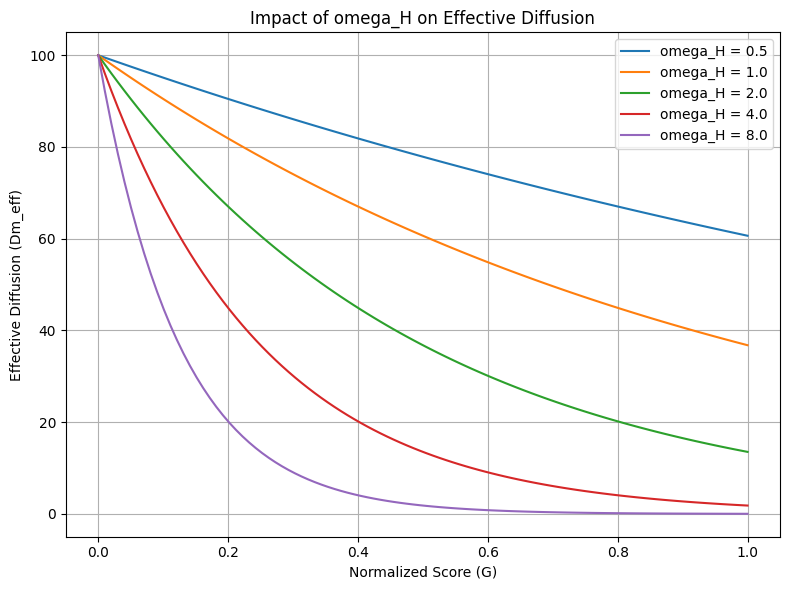

In [2]:
import numpy as np



def compute_norm_score_patch(alpha_HH, H , alpha_HV1 ,V1 , alpha_HV2 ,V2 , alpha_PH, P):

    import numpy as np

    score_G = alpha_HH * H + alpha_HV1 * V1 + alpha_HV2 * V2 + alpha_PH * P

    score_G_min = np.min(score_G)
    score_G_max = np.max(score_G)
    normalized_score_G = (score_G - score_G_min) / (score_G_max - score_G_min + 1e-9)

    return score_G, normalized_score_G


def diff_eq(H, V1, V2, P, dx, dy, sigma_H, eta_H, 
            alpha_HH, alpha_HV1, alpha_HV2, alpha_PH):

    import numpy as np

    omega_H = 2 * sigma_H

    # Use the helper function to compute the G score and its normalized version
    score_G, normalized_score_G = compute_norm_score_patch(
        alpha_HH, H, alpha_HV1, V1, alpha_HV2, V2, alpha_PH, P
    )

    # Use normalized G score to compute effective diffusion
    Dm_eff = np.exp(-omega_H * normalized_score_G) * eta_H


    # Idea provided by chatGPT to encourage movement toward favorable (high-score) areas.
    # alpha = 5

    # Dm_eff = eta_H * (1 + alpha * normalized_score_G)


    # Compute spatial gradients of H
    dHdx = (np.roll(H, -1, axis=0) - np.roll(H, 1, axis=0)) / (2 * dx)
    dHdy = (np.roll(H, -1, axis=1) - np.roll(H, 1, axis=1)) / (2 * dy)

    # Compute fluxes
    flux_x = Dm_eff * dHdx
    flux_y = Dm_eff * dHdy

    # Compute divergence of fluxes
    div_flux_x = (np.roll(flux_x, -1, axis=0) - np.roll(flux_x, 1, axis=0)) / (2 * dx)
    div_flux_y = (np.roll(flux_y, -1, axis=1) - np.roll(flux_y, 1, axis=1)) / (2 * dy)

    divergence = div_flux_x + div_flux_y

    return divergence, score_G, normalized_score_G, Dm_eff


shape = (100, 100)
H = np.random.rand(*shape)
V1 = np.random.rand(*shape)
V2 = np.random.rand(*shape)
P = np.random.rand(*shape)


alpha_vals = np.linspace(0, 10, 5)  # From 0 to 2 in 5 steps

results = []

for alpha_HH in alpha_vals:
    for alpha_HV1 in alpha_vals:
        for alpha_HV2 in alpha_vals:
            for alpha_PH in alpha_vals:
                div, score, norm_score, Dm = diff_eq(
                    H, V1, V2, P, dx=1.0, dy=1.0, sigma_H=1.0, eta_H=1.0,
                    alpha_HH=alpha_HH,
                    alpha_HV1=alpha_HV1,
                    alpha_HV2=alpha_HV2,
                    alpha_PH=alpha_PH
                )
                avg_diff = np.mean(Dm)
                results.append({
                    'alpha_HH': alpha_HH,
                    'alpha_HV1': alpha_HV1,
                    'alpha_HV2': alpha_HV2,
                    'alpha_PH': alpha_PH,
                    'avg_diffusion': avg_diff
                })


import pandas as pd
df = pd.DataFrame(results)
print(df.sort_values('avg_diffusion', ascending=False).head())


import numpy as np
import matplotlib.pyplot as plt

eta_H = 100.0  # constant diffusion rate
normalized_scores = np.linspace(0, 1, 100)  # score range from 0 to 1

plt.figure(figsize=(8, 6))

for omega_H in [0.5, 1.0, 2.0, 4.0, 8.0]:
    Dm_eff = np.exp(-omega_H * normalized_scores) * eta_H
    plt.plot(normalized_scores, Dm_eff, label=f'omega_H = {omega_H}')

plt.title('Impact of omega_H on Effective Diffusion')
plt.xlabel('Normalized Score (G)')
plt.ylabel('Effective Diffusion (Dm_eff)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
